In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

from sklearn.feature_selection import RFE
from operator import itemgetter        
        
#Scaling and Splitting
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split

#Modeling
from sklearn.linear_model import LassoLars
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#Evaluation
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

/kaggle/input/trailer-prices/trailerdata1.csv
/kaggle/input/trailer-prices/trailerdata2.csv


# About this notebook
This notebook aims to predict the price of a product (trailer) for an early stage start-up. The data has been anonymized. Due to the web infrastructure of manufacturers of similar trailers, the data was collected by hand. This project is still on-going and updated regularly. 

## Current Challenges
The data has been collected by hand as it was formatted differently for nearly every row. Some points have been imputed by hand elsewhere, based off of photos, educated guesses and industry knowledge. Enough data has been collected so that feature engineering is now underway. One major point is how to encompass the information about number of doors and windows, experimenting with different ways of tackling these columns is currently underway. 

In [2]:
#The trailer price data is saved in a csv file and must first be loaded
data = pd.read_csv('/kaggle/input/trailer-prices/trailerdata1.csv', sep=';')
data.head(5)

,total dry weight,length,Cabin exterior width,exterior height,interior height highest point,A/C,Roof Rack,Driver Side Window,Driver Side Door,Driver Side Door Window,...,Wall Material,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,Base price
0,1660,198.0,102.0,84.0,54.0,2,2,2,0,0,...,Wood,2,1,2,2,1,2,2,2,14879
1,1320,144.0,102.0,90.0,54.0,2,2,2,0,0,...,Wood,2,1,2,2,1,2,2,2,12500
2,1320,144.0,102.0,90.0,54.0,2,2,2,0,0,...,Wood,2,1,2,2,1,2,2,2,14997
3,1930,185.0,102.0,105.0,73.0,2,2,2,0,0,...,Wood,2,1,2,2,1,2,2,2,15965
4,2260,188.0,102.0,108.0,74.0,2,2,2,0,0,...,Wood,2,1,2,2,0,2,2,2,18689


In [3]:
#inspect the data types of each column
#for modeling everything needs to be and int or float
data.dtypes

total dry weight                   int64
length                           float64
Cabin exterior width             float64
exterior height                  float64
interior height highest point    float64
A/C                                int64
Roof Rack                          int64
Driver Side Window                 int64
Driver Side Door                   int64
Driver Side Door Window            int64
Passenger Side Door                int64
Passenger Side Door Window         int64
Passenger Side Window              int64
Rear Door Window                   int64
Usage Intent- On or Off Road      object
Rear Door                         object
Wall Material                     object
Spare Tire                         int64
Battery Power Supply               int64
Cabinets                           int64
Refrigerator                       int64
Awning                             int64
Solar                              int64
STOVE                              int64
USB Charging    

In [4]:
#checking for missing values
#missing values must be dealt with for ML modeling
data.isna().sum()

total dry weight                 0
length                           0
Cabin exterior width             0
exterior height                  0
interior height highest point    0
A/C                              0
Roof Rack                        0
Driver Side Window               0
Driver Side Door                 0
Driver Side Door Window          0
Passenger Side Door              0
Passenger Side Door Window       0
Passenger Side Window            0
Rear Door Window                 0
Usage Intent- On or Off Road     0
Rear Door                        0
Wall Material                    0
Spare Tire                       0
Battery Power Supply             0
Cabinets                         0
Refrigerator                     0
Awning                           0
Solar                            0
STOVE                            0
USB Charging                     0
Base price                       0
dtype: int64

There are no missing values because the data has been imputed by hand beforehand. 

In [5]:
data.shape

(95, 26)

In [6]:
#these columns will be renamed to remove the space in the heading 
data = data.rename(columns={"Usage Intent- On or 2": "Usage Intent- On or Off Road", "exterior height": "eheight", "total dry weight": "tdweight", "interior height":"intheight", "exterior width":"ewidth", "Base price":"price"})

In [7]:
#checking the categories are clean
data['Passenger Side Door Window'].value_counts()

2    70
1    19
0     6
Name: Passenger Side Door Window, dtype: int64

In [8]:
#data2['intheight'] = data2['intheight'].fillna(data2['intheight'].mean())
#data2['ewidth'] = data2['ewidth'].fillna(data2['ewidth'].mean())

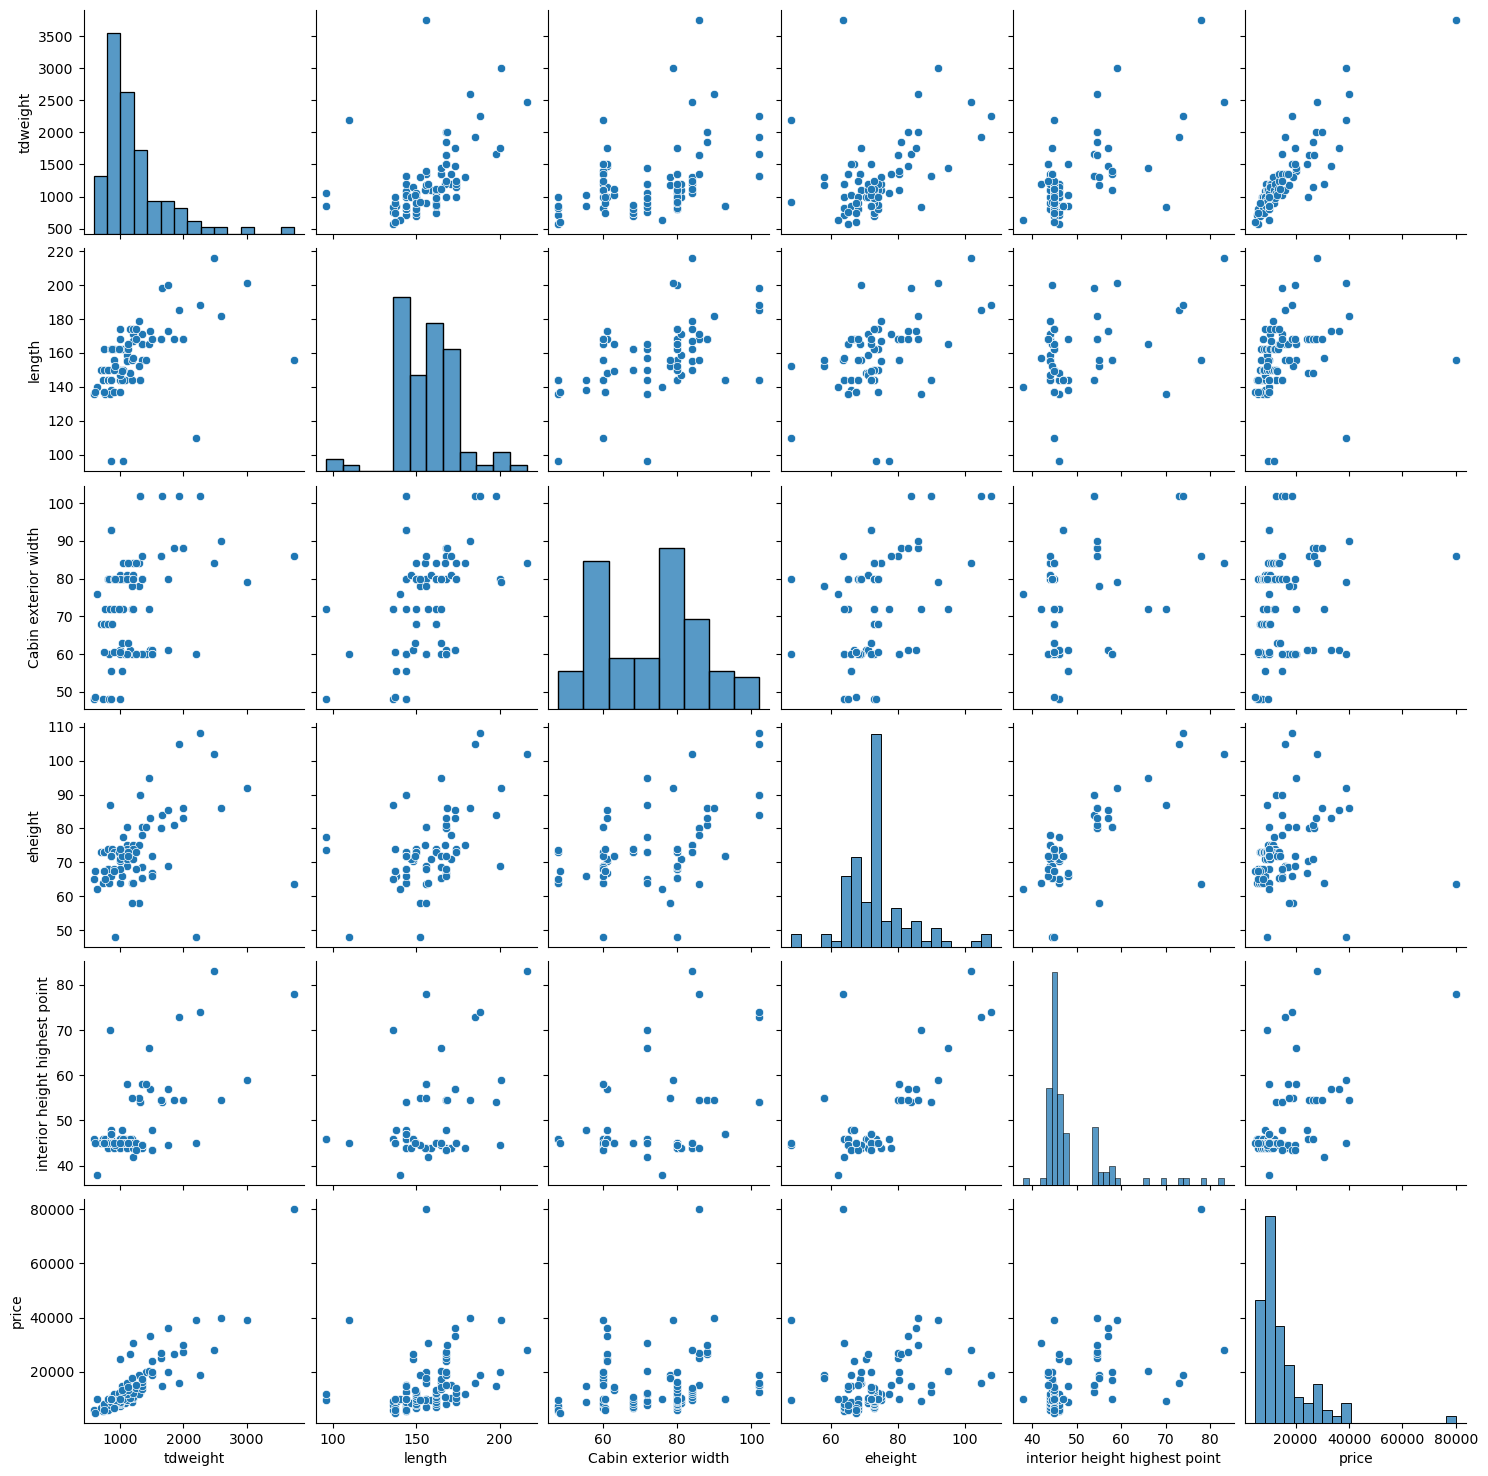

In [9]:
sns.pairplot(data[['tdweight', 'length', 'Cabin exterior width', 'eheight', 'interior height highest point', 'price']])

Of all the variables, total dry weight appears to be the most correlated with the price. Let's look at it a bit more closely. 

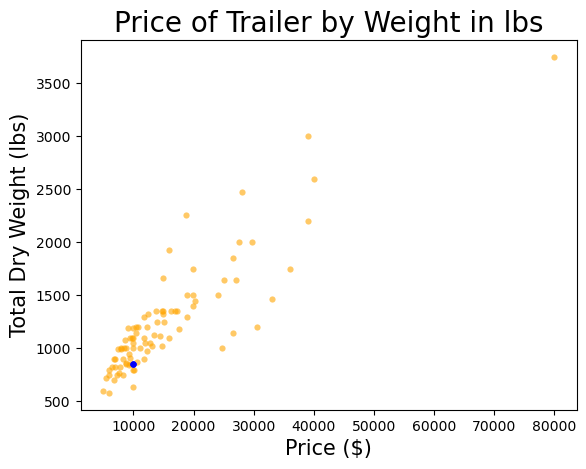

In [10]:
# values of x
x=data['price']
y= data['tdweight']

col = []
  
for i in range(0, len(x)):
    #the target trailer in blue
    if x[i]==9995:
        col.append('blue')  
    #all other trailers in orange
    else:
        col.append('orange') 
  
for i in range(len(x)):
      
    # plotting the corresponding x with y 
    # and respective color
    plt.scatter(x[i], y[i], c = col[i], s = 20,
                linewidth = 0, alpha=0.6)
    plt.title("Price of Trailer by Weight in lbs", fontsize=20)
    plt.ylabel("Total Dry Weight (lbs)", fontsize=15)
    plt.xlabel("Price ($)", fontsize=15)
      
plt.show()

In [11]:
#drop the very expensive heavy trailer outlier
data=data.drop(data.index[75])

Now let's look at how a few features map onto the weight vs. price

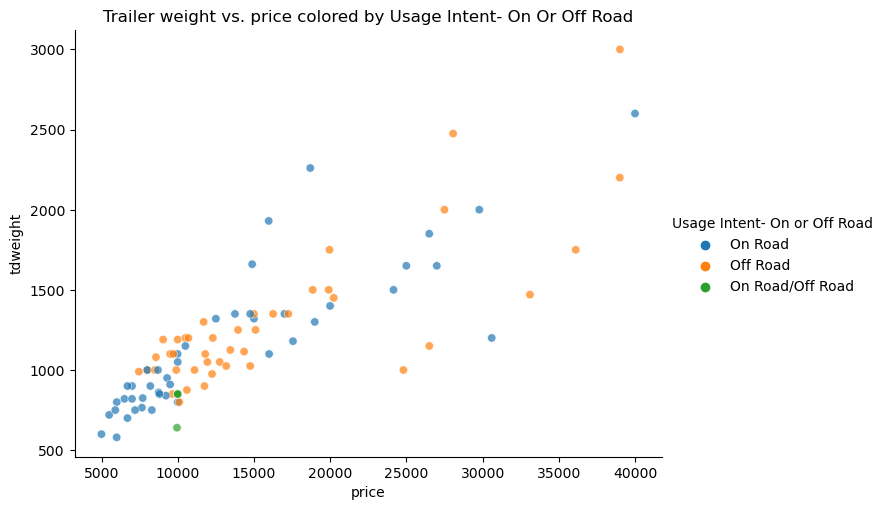

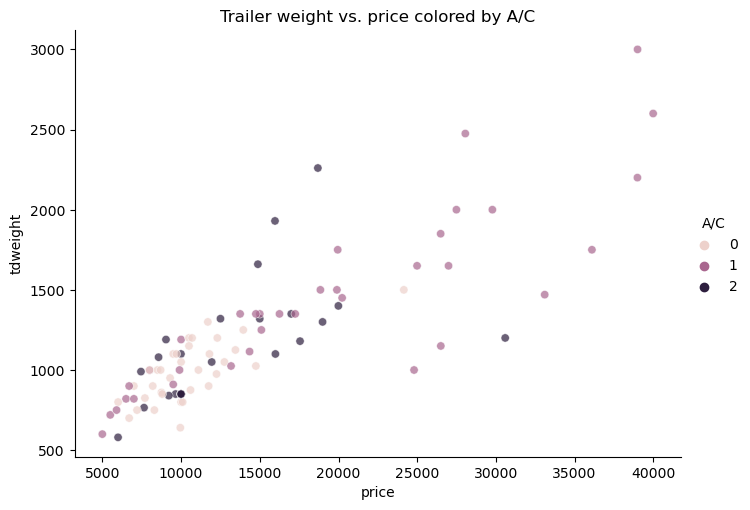

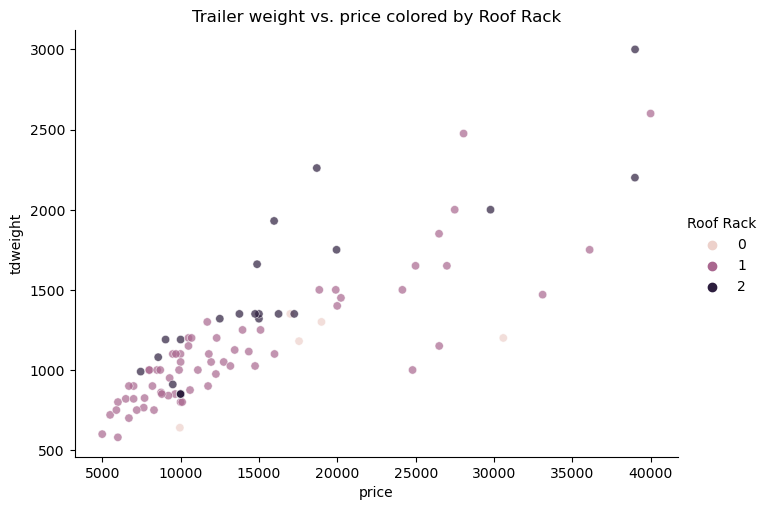

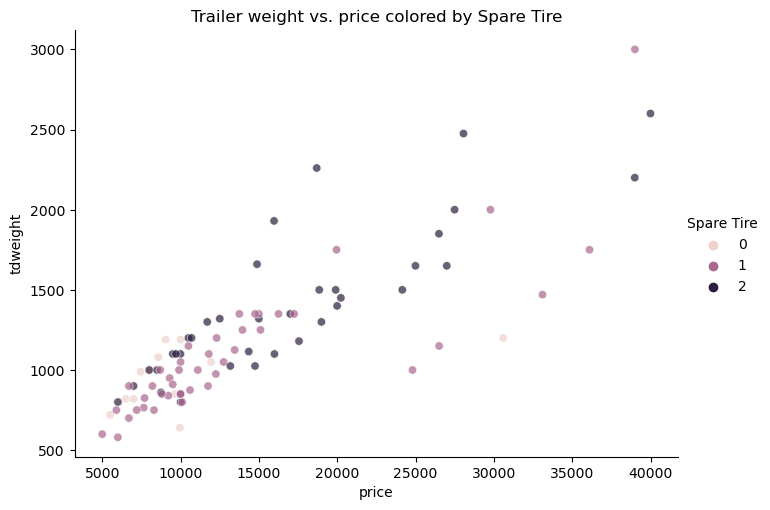

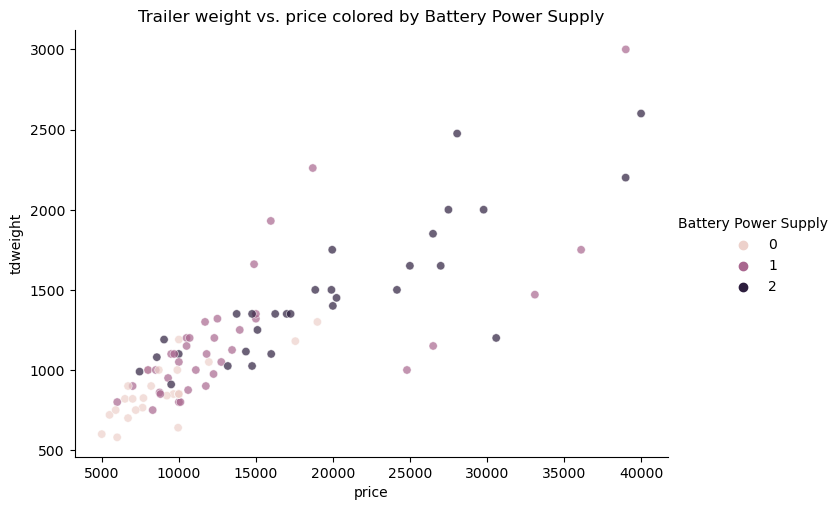

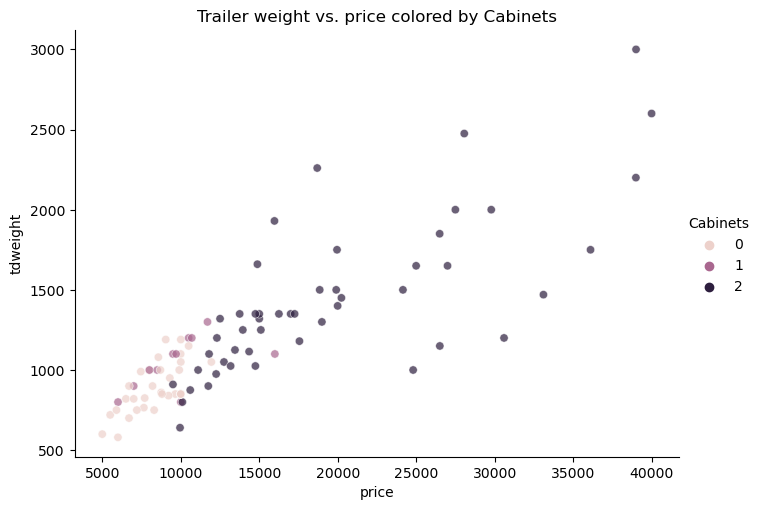

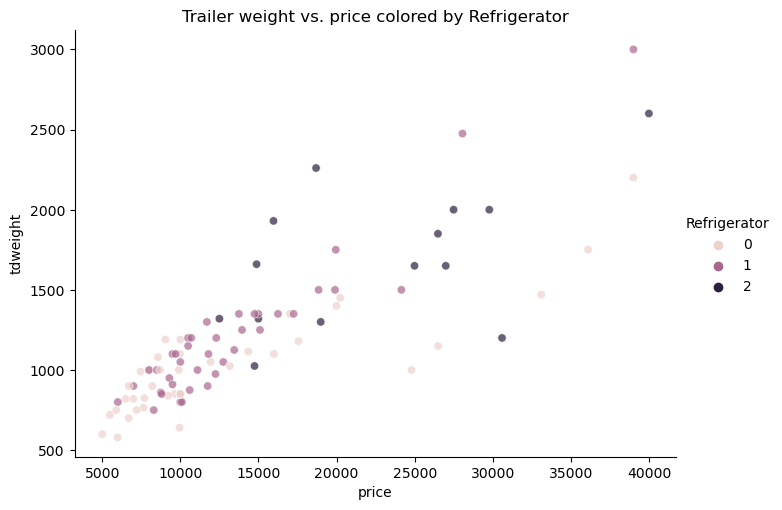

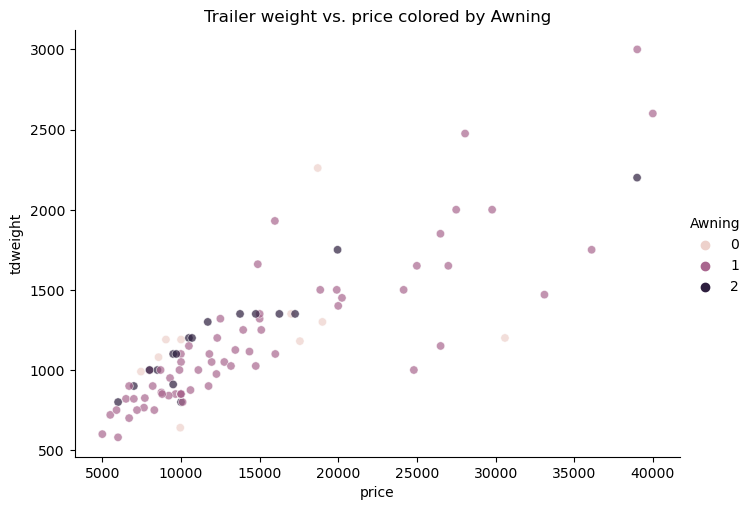

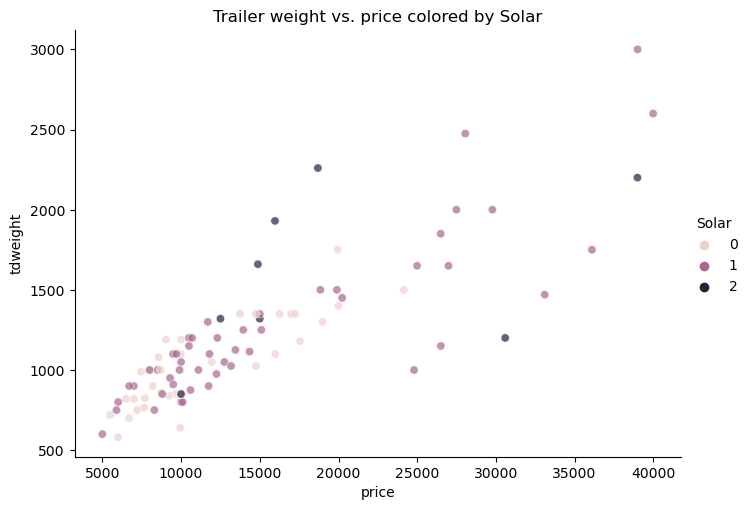

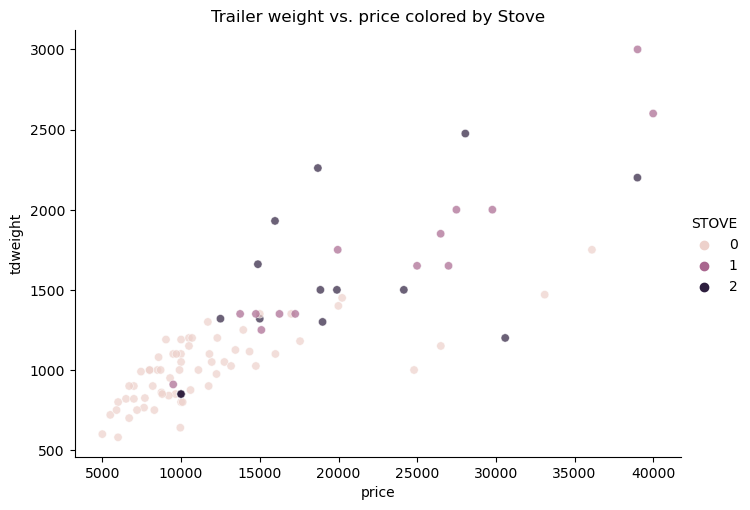

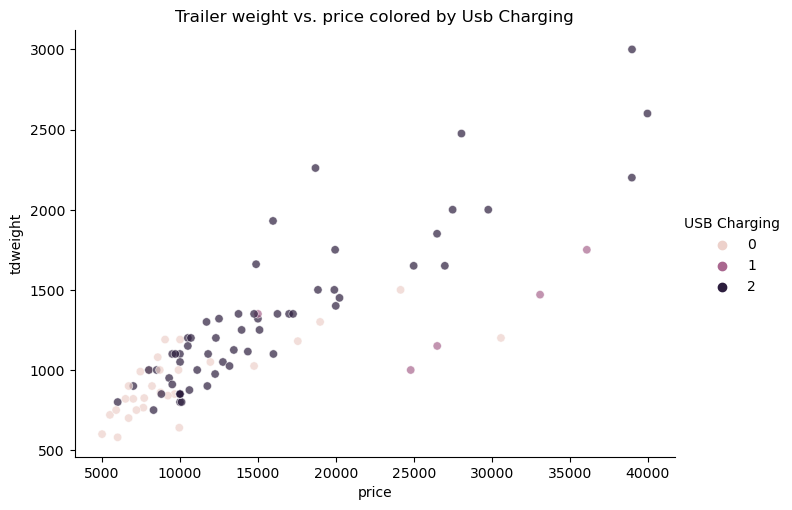

In [12]:
for c in ['Usage Intent- On or Off Road', 'A/C', 'Roof Rack', 'Spare Tire', 'Battery Power Supply', 'Cabinets', 'Refrigerator', 'Awning', 'Solar', 'STOVE', 'USB Charging']:
    sns.relplot(data=data, x='price', y='tdweight', hue=f"{c}", aspect=1.4, alpha=0.7)
    plt.title(f'Trailer weight vs. price colored by {c.title()}')
    plt.show()

In [13]:
#These features are highly negatively correlated and contain rather repetitive data
#Relevant columns are added together to reduce complexity
#No:0, Option:1, Yes:2
data["Windows"] = data["Driver Side Window"] + data["Passenger Side Window"]
data["Doors"] = data["Driver Side Door"] + data["Passenger Side Door"]
data["Door Windows"] = data["Driver Side Door Window"] + data["Passenger Side Door Window"]

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94 entries, 0 to 94
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   tdweight                       94 non-null     int64  
 1   length                         94 non-null     float64
 2   Cabin exterior width           94 non-null     float64
 3   eheight                        94 non-null     float64
 4   interior height highest point  94 non-null     float64
 5   A/C                            94 non-null     int64  
 6   Roof Rack                      94 non-null     int64  
 7   Driver Side Window             94 non-null     int64  
 8   Driver Side Door               94 non-null     int64  
 9   Driver Side Door Window        94 non-null     int64  
 10  Passenger Side Door            94 non-null     int64  
 11  Passenger Side Door Window     94 non-null     int64  
 12  Passenger Side Window          94 non-null     int64

In [15]:
#reorder the columns so there are no problems with slicing/encoding
data = data[['tdweight', 'length', 'Cabin exterior width', 'eheight', 'interior height highest point', 'Windows', 'Doors', 'Door Windows', 'Rear Door Window', 'Rear Door', 'Wall Material', 'Usage Intent- On or Off Road', 'A/C', 'Roof Rack', 'Spare Tire', 'Battery Power Supply', 'Cabinets', 'Refrigerator', 'Awning', 'Solar', 'STOVE', 'USB Charging', 'price']]

In [16]:
#checking the columns are reordered
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94 entries, 0 to 94
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   tdweight                       94 non-null     int64  
 1   length                         94 non-null     float64
 2   Cabin exterior width           94 non-null     float64
 3   eheight                        94 non-null     float64
 4   interior height highest point  94 non-null     float64
 5   Windows                        94 non-null     int64  
 6   Doors                          94 non-null     int64  
 7   Door Windows                   94 non-null     int64  
 8   Rear Door Window               94 non-null     int64  
 9   Rear Door                      94 non-null     object 
 10  Wall Material                  94 non-null     object 
 11  Usage Intent- On or Off Road   94 non-null     object 
 12  A/C                            94 non-null     int64

In [17]:
#select the categorical data for encoding
#cat_data = data.iloc[:, 13:16]
#cat_data

In [18]:
cat_data = data[['Rear Door', 'Wall Material', 'Usage Intent- On or Off Road']]
cat_data

,Rear Door,Wall Material,Usage Intent- On or Off Road
0,GALLEY,Wood,On Road
1,GALLEY,Wood,On Road
2,GALLEY,Wood,On Road
3,GALLEY,Wood,On Road
4,No,Wood,On Road
...,...,...,...
90,Yes,Fiberglass,On Road/Off Road
91,Yes,Fiberglass,On Road/Off Road
92,Yes,Fiberglass,On Road/Off Road
93,Yes,Fiberglass,On Road/Off Road


In [19]:
#doesn't help
#created dummy variables from categories (also can use OneHotEncoder)
#all_dummies = pd.get_dummies(data[['tdweight', 'length', 'Cabin exterior width', 'eheight', 'interior height highest point', 'Windows', 'Doors', 'Door Windows', 'Usage Intent- On or Off Road', 'A/C', 'Roof Rack', 'Spare Tire', 'Battery Power Supply', 'Cabinets', 'Refrigerator', 'Awning', 'Solar', 'STOVE', 'USB Charging', 'USB Cost', 'price']])

In [20]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()

#label encode the data to prepare for modeling
#label encoding is preferred for categorical variables

for col in cat_data:
    data[col] = labelencoder.fit_transform(data[col])
 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94 entries, 0 to 94
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   tdweight                       94 non-null     int64  
 1   length                         94 non-null     float64
 2   Cabin exterior width           94 non-null     float64
 3   eheight                        94 non-null     float64
 4   interior height highest point  94 non-null     float64
 5   Windows                        94 non-null     int64  
 6   Doors                          94 non-null     int64  
 7   Door Windows                   94 non-null     int64  
 8   Rear Door Window               94 non-null     int64  
 9   Rear Door                      94 non-null     int64  
 10  Wall Material                  94 non-null     int64  
 11  Usage Intent- On or Off Road   94 non-null     int64  
 12  A/C                            94 non-null     int64

In [21]:
#dropping columns which aren't useful 
data = data.drop(['interior height highest point'], axis=1)

In [22]:
#make a copy of the data for later
data2=data

In [23]:
corr=data2.corr()
corr

,tdweight,length,Cabin exterior width,eheight,Windows,Doors,Door Windows,Rear Door Window,Rear Door,Wall Material,...,Roof Rack,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,price
tdweight,1.000000,0.613997,0.329399,0.537724,-0.008660,0.031557,0.112232,-0.183088,-0.197693,-0.156651,...,0.252262,0.377434,0.530494,0.574236,0.489002,-0.003342,0.358372,0.538957,0.391659,0.834499
length,0.613997,1.000000,0.405851,0.471777,-0.056548,0.104212,0.305812,-0.156826,-0.414434,0.200926,...,0.094195,0.369232,0.413893,0.483586,0.471607,0.099328,0.272562,0.290038,0.466761,0.407046
Cabin exterior width,0.329399,0.405851,1.000000,0.436676,0.160436,-0.204582,-0.000116,0.330206,0.056532,-0.235974,...,0.330007,0.343604,0.003837,0.251791,0.548235,0.163335,0.422620,0.413628,0.492618,0.115917
eheight,0.537724,0.471777,0.436676,1.000000,0.266678,-0.212855,-0.138522,-0.034880,-0.153280,-0.007857,...,0.192187,0.279340,0.160686,0.214781,0.319477,-0.173660,0.362851,0.216654,0.309893,0.315455
Windows,-0.008660,-0.056548,0.160436,0.266678,1.000000,-0.386895,-0.381019,0.167660,0.245811,-0.265318,...,-0.099949,0.085855,-0.137800,-0.095353,0.134483,-0.316478,0.066774,-0.077304,0.095832,-0.179587
Doors,0.031557,0.104212,-0.204582,-0.212855,-0.386895,1.000000,0.657837,-0.383876,-0.496503,0.289238,...,-0.115119,-0.313847,0.261374,0.120280,0.116540,0.061092,-0.058051,-0.159830,-0.071593,0.153619
Door Windows,0.112232,0.305812,-0.000116,-0.138522,-0.381019,0.657837,1.000000,-0.186736,-0.519216,0.328505,...,-0.090259,-0.020331,0.305210,0.350397,0.266280,0.066174,0.150154,0.058245,0.183803,0.280456
Rear Door Window,-0.183088,-0.156826,0.330206,-0.034880,0.167660,-0.383876,-0.186736,1.000000,0.753637,-0.550480,...,0.365541,-0.090672,-0.314359,-0.296803,-0.238300,-0.033256,-0.111559,0.230158,0.074866,-0.128961
Rear Door,-0.197693,-0.414434,0.056532,-0.153280,0.245811,-0.496503,-0.519216,0.753637,1.000000,-0.665964,...,0.171186,-0.266233,-0.446111,-0.378161,-0.394964,-0.200188,-0.305725,0.154182,-0.195132,-0.127383
Wall Material,-0.156651,0.200926,-0.235974,-0.007857,-0.265318,0.289238,0.328505,-0.550480,-0.665964,1.000000,...,-0.027751,0.036352,0.180375,0.085572,0.018681,0.275328,0.151852,-0.283349,0.119152,-0.265673


<AxesSubplot:>

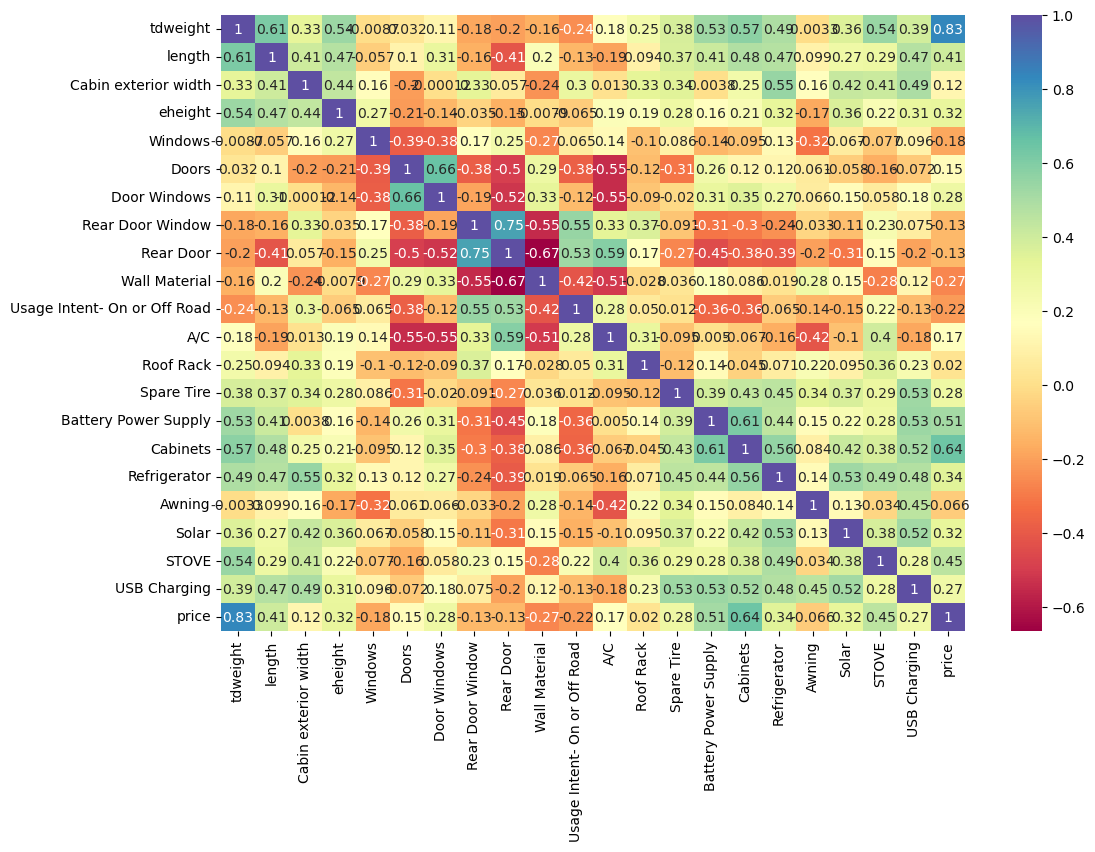

In [24]:
plt.figure(figsize=(12,8))
sns.heatmap(corr,annot=True,cmap="Spectral")

The concept of correlation measures the degree of association between features or the target variable. It can either be positive, which means an increase in the value of one feature results in an increase in the target variable, or negative, where an increase in the value of one feature results in a decrease in the target variable.

By plotting a heatmap of correlated features using the Seaborn library, it becomes easier to determine which features are strongly related to the target variable.

Here we can see that the weight has by far the largest correlation with price, however some luxury features like battery power supply, cabinets and stove also have a high correlation with price. 

# Machine Learning Modeling
The data is now clean and we can move forward with creating some machine learning models. Once we settle on the best model it can be used to predict the target price of the trailer in question.

In [25]:
data2=data2.drop(data.index[90:])

In [26]:
data2

,tdweight,length,Cabin exterior width,eheight,Windows,Doors,Door Windows,Rear Door Window,Rear Door,Wall Material,...,Roof Rack,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,price
0,1660,198.0,102.0,84.0,4,2,2,0,0,6,...,2,2,1,2,2,1,2,2,2,14879
1,1320,144.0,102.0,90.0,4,2,2,0,0,6,...,2,2,1,2,2,1,2,2,2,12500
2,1320,144.0,102.0,90.0,4,2,2,0,0,6,...,2,2,1,2,2,1,2,2,2,14997
3,1930,185.0,102.0,105.0,4,2,2,0,0,6,...,2,2,1,2,2,1,2,2,2,15965
4,2260,188.0,102.0,108.0,4,2,2,0,1,6,...,2,2,1,2,2,0,2,2,2,18689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,600,137.0,48.5,67.5,3,3,3,0,0,6,...,1,1,0,0,0,1,1,0,0,4995
87,900,137.0,60.5,67.5,3,3,3,0,0,6,...,1,1,0,0,0,1,1,0,0,6700
88,750,137.0,60.5,67.5,3,3,3,0,0,6,...,1,1,0,0,0,1,1,0,0,5900
89,1000,137.0,60.5,74.0,3,3,3,0,0,6,...,1,1,0,0,0,1,1,0,0,9900


In [27]:
#here the data is split up into X,y where X contains everything but price and y contains what we want to predict (price)
#price is what we want to predict

X = data2.drop(['price'],axis=1)
y=data2['price']

In [28]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [29]:
#scaling the data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
#function which runs different ML models and prints R^2, MAE and RMSE
def run_experiment(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    #EVALUATION OF THE MODEL
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("MSE :", mean_squared_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    # Plotting y_test and y_pred 
    fig = plt.figure()
    plt.scatter(y_test,y_pred)
    fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
    plt.xlabel('y_test', fontsize=18)                          # X-label
    plt.ylabel('y_pred', fontsize=18) 

Now the data is all cleaned up and ready for creating some machine learning models. A funtion has been written to run various models and output common regression metrics: 



*Mean Absolute Error (MAE)* is the mean of the absolute value of the errors

*Mean Squared Error (MSE)* is the mean of the squared errors

*Root Mean Squared Error (RMSE)* is the square root of the mean of the squared errors

**The metrics compared:**

In comparing different metrics, the MAE represents the average error and is the most straightforward to comprehend. Meanwhile, the MSE is more commonly used than MAE as it penalizes larger errors, making it more relevant in real-world scenarios. The RMSE, on the other hand, is more widely used than MSE since it can be interpreted in the same units as the "y" variable. All of these are considered loss functions, as the objective is to minimize their values.

R^2 :  0.6537132422101152
MAE : 3232.539946661515
MSE : 19092785.45525671
RMSE: 4369.529202929843


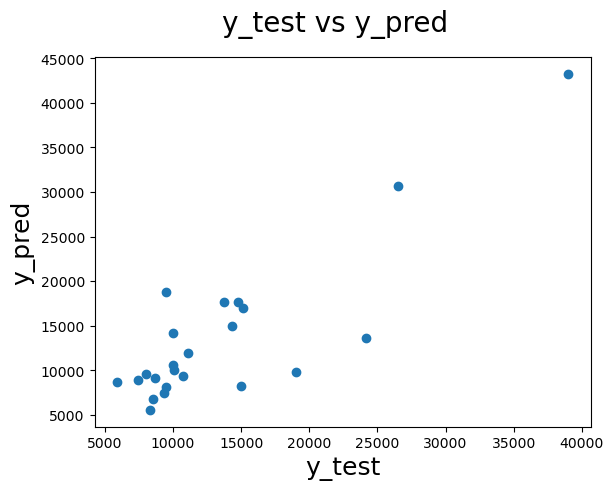

In [31]:
model_1 = LinearRegression()
run_experiment(model_1)

R^2 :  0.5675524435049515
MAE : 2703.7391304347825
MSE : 23843327.04347826
RMSE: 4882.962936934732


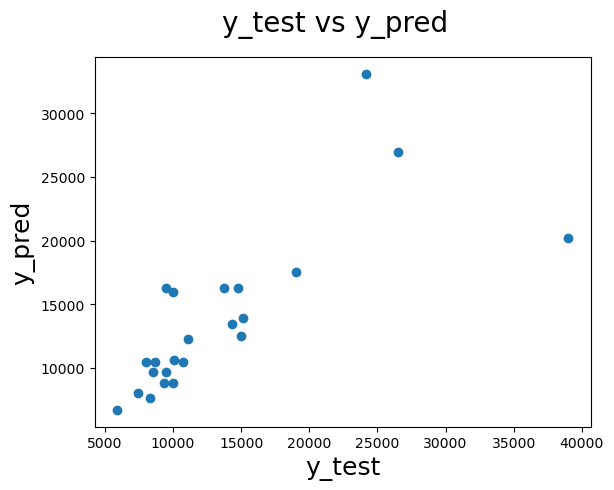

In [32]:
model_2 = DecisionTreeRegressor(random_state = 1)
run_experiment(model_2)

R^2 :  0.575298399890348
MAE : 3486.521236043255
MSE : 23416247.80904248
RMSE: 4839.033768123806


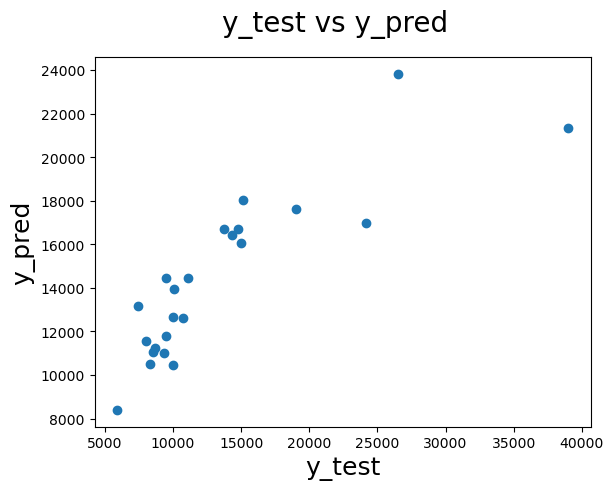

In [33]:
model_3 = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=1)
run_experiment(model_3)

R^2 :  0.6827309499806395
MAE : 2922.9364488488322
MSE : 17492871.925782032
RMSE: 4182.448078073658


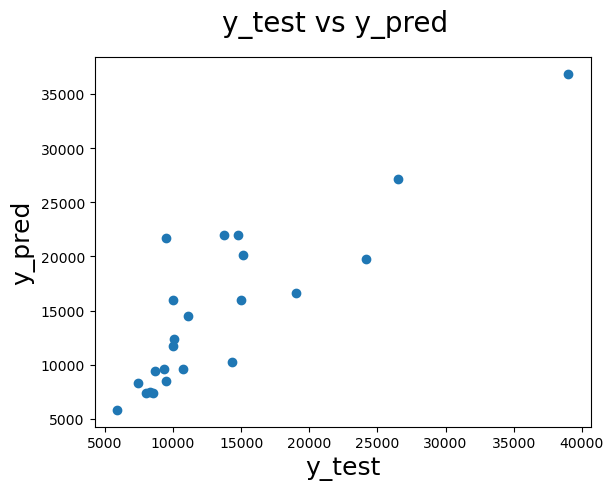

In [34]:
model_4 = Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=1)
run_experiment(model_4)

R^2 :  0.7068418247264588
MAE : 2966.6811787258725
MSE : 16163500.391050072
RMSE: 4020.3856022837003


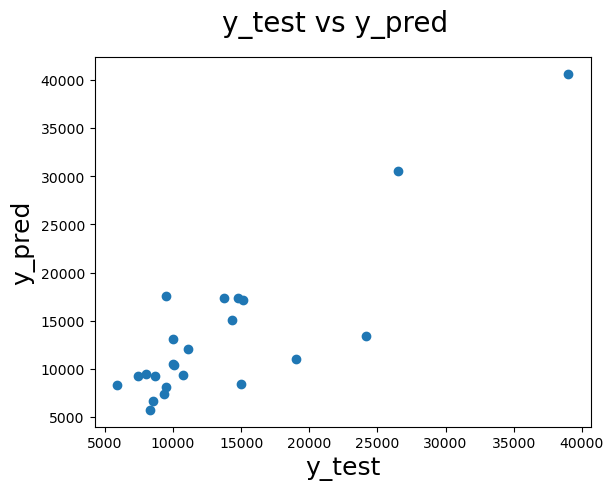

In [35]:
model_5 = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=1)
run_experiment(model_5)

R^2 :  0.7201439391003495
MAE : 2887.9609569529534
MSE : 15430078.132968564
RMSE: 3928.113813647533


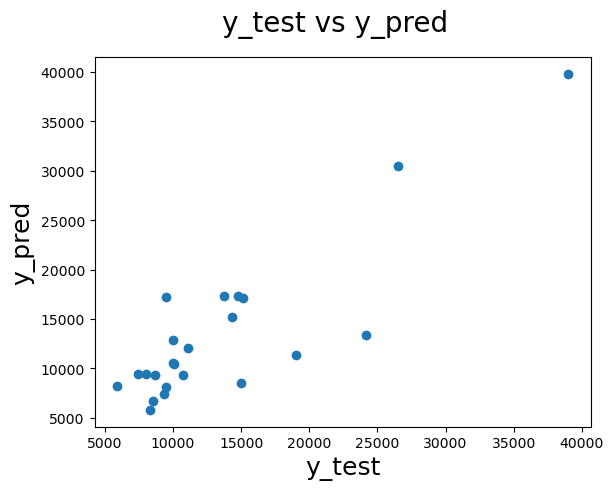

In [36]:
model_7 = BayesianRidge()
run_experiment(model_7)

R^2 :  0.705675136243606
MAE : 2899.259196590139
MSE : 16227826.653591549
RMSE: 4028.37767017835


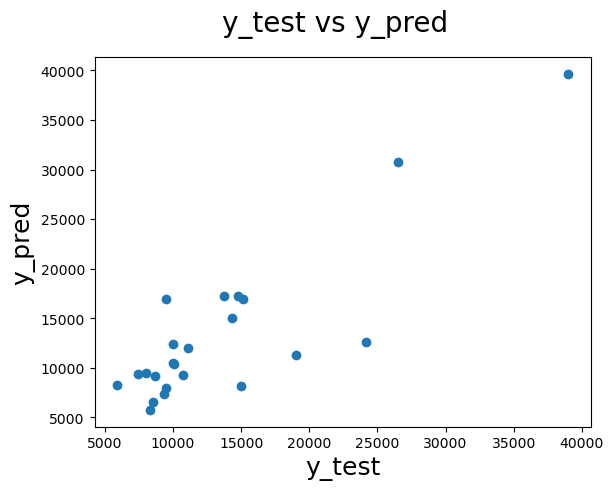

In [37]:
model_8 = SGDRegressor(max_iter=1000, tol=1e-3)
run_experiment(model_8)

R^2 :  -0.024183475425363588
MAE : 5031.162174418016
MSE : 56469139.87678581
RMSE: 7514.59512394286


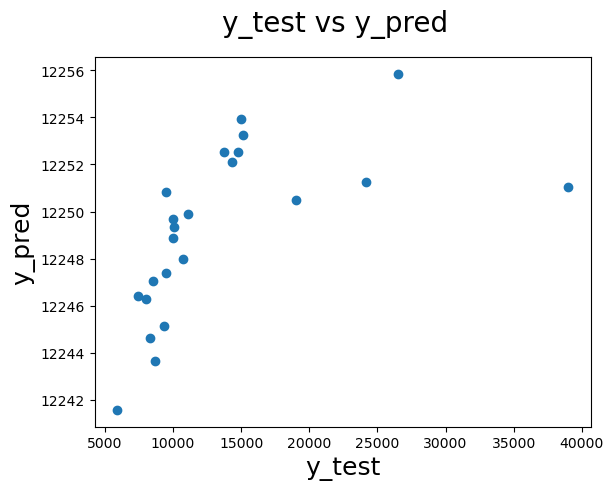

In [38]:
model_9 = SVR(epsilon=0.2)
run_experiment(model_9)

R^2 :  0.7209276930903035
MAE : 2362.759079757199
MSE : 15386865.25680952
RMSE: 3922.6094958343124


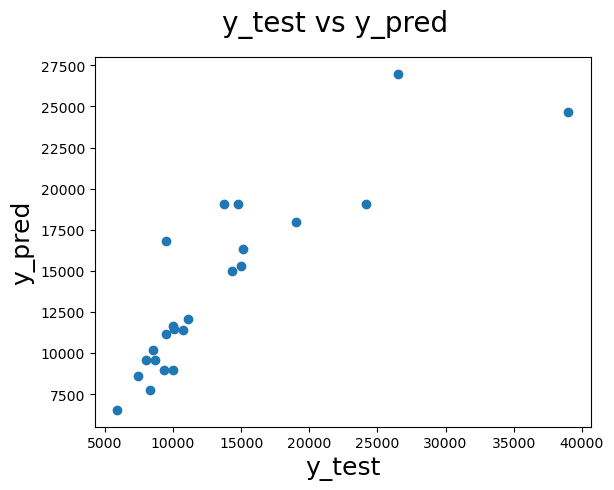

In [39]:
model_10 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_10)

RandomForest preformed better than all the other models tested. Therefore we will move forward with tuning hyperparameters to figure out which produce the best result.

# Checking Feature Importance for Feature Engineering

## Chi-squared (χ²) test

In [40]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = data2.drop(['price'],axis=1)
y=data2['price']
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
#naming the columns
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(25,'Score'))  

                           Specs         Score
0                       tdweight  14840.381067
2           Cabin exterior width    204.470333
1                         length    200.549106
7               Rear Door Window    178.000000
3                        eheight    121.154337
19                         STOVE    107.657895
8                      Rear Door     99.793103
4                        Windows     80.673307
15                      Cabinets     60.678899
9                  Wall Material     59.614865
11                           A/C     59.168831
16                  Refrigerator     57.925373
20                  USB Charging     54.826087
14          Battery Power Supply     47.278351
10  Usage Intent- On or Off Road     45.591837
18                         Solar     44.142857
6                   Door Windows     39.920455
13                    Spare Tire     27.710526
17                        Awning     21.298969
12                     Roof Rack     18.428571
5            

The *chi-squared (χ²) test* is a statistical hypothesis test used to determine the independence of two categorical variables. It is commonly used in machine learning to test the relationship between a feature and a target variable.

The chi-squared test is applicable only to non-negative features and is based on the assumption that the expected frequency of each category should be at least 5. If the expected frequency is less than 5, then the test result may not be reliable.

In the chi-squared test, the observed frequencies of each category are compared to the expected frequencies. The expected frequency of each category is calculated based on the null hypothesis of independence between the feature and the target variable. If the observed frequency significantly deviates from the expected frequency, then the null hypothesis is rejected, indicating that the feature is associated with the target variable.

The chi-squared test outputs a p-value, which represents the probability of observing the test results given that the null hypothesis is true. A small p-value indicates that the feature and target variable are likely associated, while a large p-value suggests that they are independent.

In general, a higher SelectKBest score indicates that the feature is more strongly associated with the target variable, and thus more relevant for the model. Conversely, a lower score indicates that the feature is less important for predicting the target variable.

## Extra Tree Classifier Top 10 Features 

[0.20695637 0.13721299 0.11741994 0.11135121 0.03397605 0.03061737
 0.03352942 0.00315246 0.0214379  0.02687295 0.03806621 0.02099083
 0.0264549  0.02726285 0.02780266 0.02640618 0.02439472 0.02580203
 0.02365417 0.02031848 0.01632029]


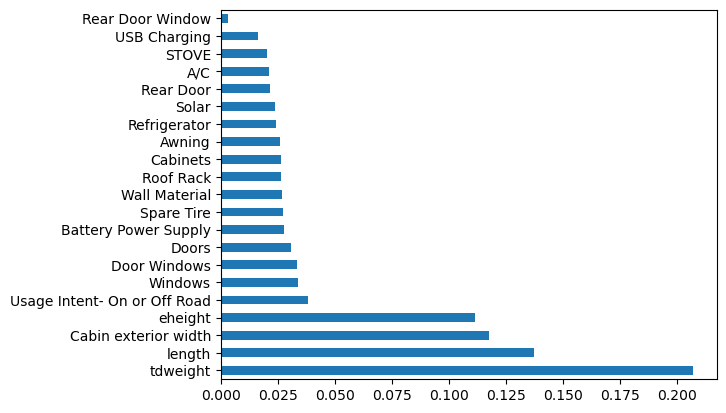

In [41]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()

To obtain the feature importance of a dataset, one can utilize the feature importance property of the model being used. This property generates a score for each feature, with a higher score indicating greater importance or relevance to the output variable.

The feature importance function is a pre-existing class that is available in Tree-Based Classifiers. In this instance, we will utilize the Extra Tree Classifier to identify the top features of the dataset.

We can see weight is still the most highly correlated to price, followed by other dimensions, On/Off Road and doors/windows. These features are vasty different from the features indicated to be most highly correlated with the price (heatmap).

## Correlation  

In [42]:
#these features have the highest correlation with price
top_corr = data2
corr_matrix = top_corr.corr()
print(corr_matrix["price"].sort_values(ascending=False))

price                           1.000000
tdweight                        0.832351
Cabinets                        0.639483
STOVE                           0.524088
Battery Power Supply            0.505242
length                          0.397530
Refrigerator                    0.328696
Solar                           0.327537
eheight                         0.314120
USB Charging                    0.289376
Spare Tire                      0.276977
Door Windows                    0.266848
A/C                             0.213569
Cabin exterior width            0.157548
Doors                           0.122581
Roof Rack                       0.061454
Rear Door Window               -0.059333
Rear Door                      -0.068498
Awning                         -0.069792
Windows                        -0.165411
Usage Intent- On or Off Road   -0.185195
Wall Material                  -0.371556
Name: price, dtype: float64


# Regressive Feature Selection
Recursive feature elimination is an example of backward feature elimination in which we essentially first fit our model using all the features in a given set, then progressively one by one we remove the least significant features, each time re-fitting, until we are left with the desired number of features, which is set by the parameter n_features_to_select

In [43]:
regressor = RandomForestRegressor(n_estimators=100, max_depth=10)

# perform a scikit-learn Recursive Feature Elimination (RFE)

#we want only one final feature to produce a ranking
n_features_to_select = 1
rfe = RFE(regressor, n_features_to_select=n_features_to_select)
rfe.fit(X_train, y_train)

# print out features in order of ranking
features = X_train.columns.to_list()
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)

# choose top 10 featues and use them for the model
n_features_to_select = 10
rfe = RFE(regressor, n_features_to_select=n_features_to_select)
rfe.fit(X_train, y_train)

# use the model to predict the prices for the test data
predictions = rfe.predict(X_test)

1 tdweight
2 Cabinets
3 Windows
4 STOVE
5 Wall Material
6 A/C
7 USB Charging
8 Cabin exterior width
9 eheight
10 length
11 Spare Tire
12 Doors
13 Solar
14 Refrigerator
15 Battery Power Supply
16 Roof Rack
17 Awning
18 Door Windows
19 Usage Intent- On or Off Road
20 Rear Door
21 Rear Door Window


# Feature Engineering
This section is in progress while more feature data is collected.

In [44]:
#the last columns contain values we want to predict
data3=data.drop(data.index[90:])

In [45]:
#removing features which preformed worst in numerous tests 
X = data3.drop(['price', 'Wall Material', 'Rear Door', 'Rear Door Window'],axis=1)
y=data3['price']

In [46]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [47]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [48]:
def run_experiment(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("MSE :", mean_squared_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    #EVALUATION OF THE MODEL
    # Plotting y_test and y_pred to understand the spread.
    fig = plt.figure()
    plt.scatter(y_test,y_pred)
    fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
    plt.xlabel('y_test', fontsize=18)                          # X-label
    plt.ylabel('y_pred', fontsize=18) 

R^2 :  0.7130755942058331
MAE : 3106.5086178375304
MSE : 15819796.739178292
RMSE: 3977.4108084504287


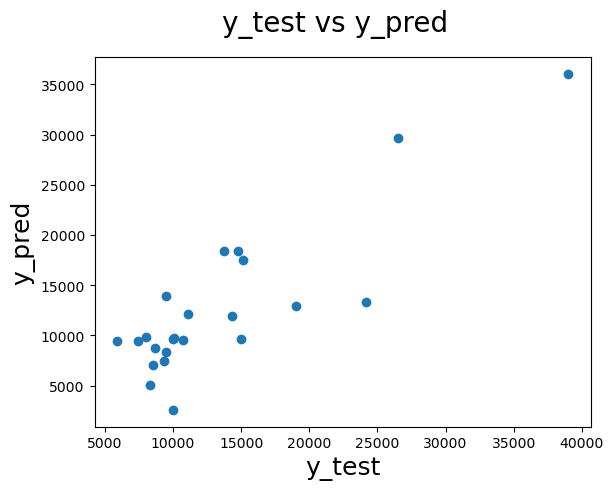

In [49]:
model_1 = LinearRegression()
run_experiment(model_1)

R^2 :  0.516919734387216
MAE : 2882.5652173913045
MSE : 26635000.217391305
RMSE: 5160.910793395998


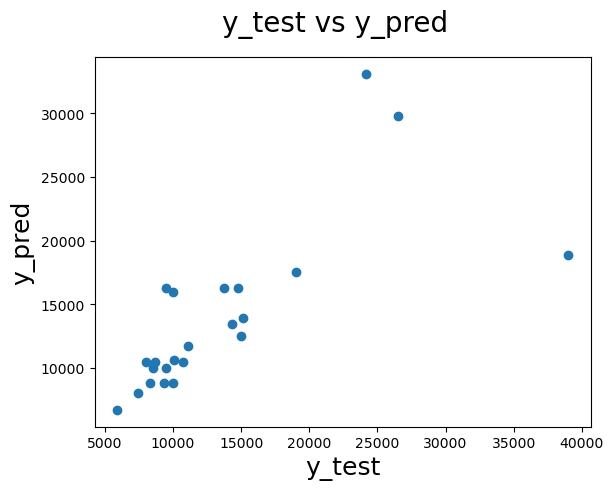

In [50]:
model_2 = DecisionTreeRegressor(random_state = 1)
run_experiment(model_2)

R^2 :  0.4754460792914239
MAE : 4102.985058706284
MSE : 28921681.93702477
RMSE: 5377.888241403382


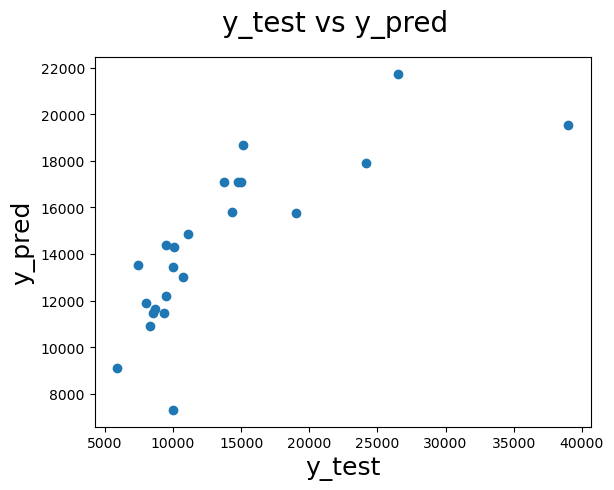

In [51]:
model_3 = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=1)
run_experiment(model_3)

R^2 :  0.7038717706834604
MAE : 2955.9475245636604
MSE : 16327256.59413276
RMSE: 4040.700012885485


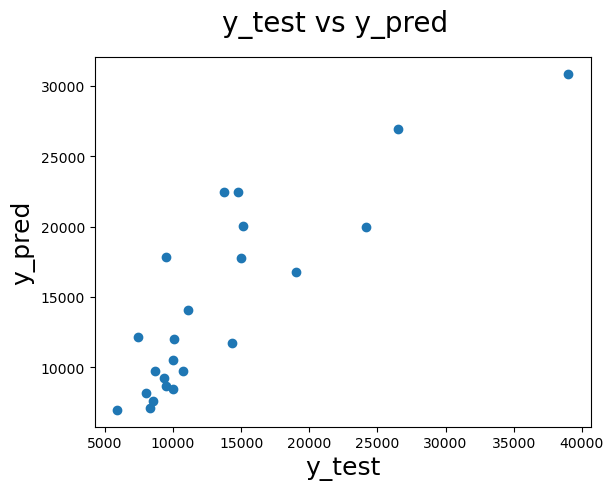

In [52]:
model_4 = Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=1)
run_experiment(model_4)

R^2 :  0.7266306527518367
MAE : 3046.5289343297495
MSE : 15072428.210551726
RMSE: 3882.322527888651


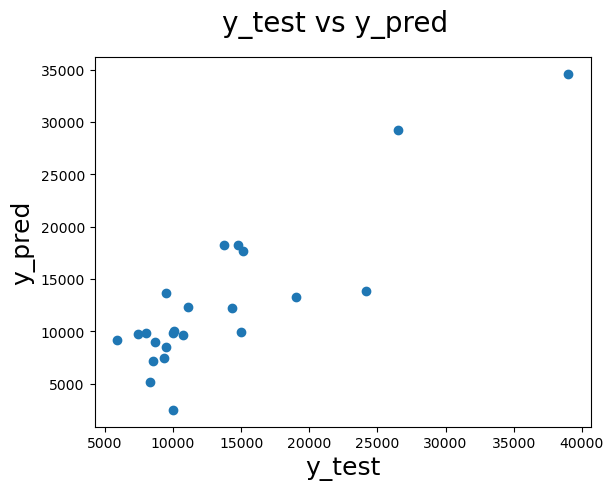

In [53]:
model_5 = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=1)
run_experiment(model_5)

R^2 :  0.7293335402748389
MAE : 3031.4345029656165
MSE : 14923402.438051116
RMSE: 3863.081986969875


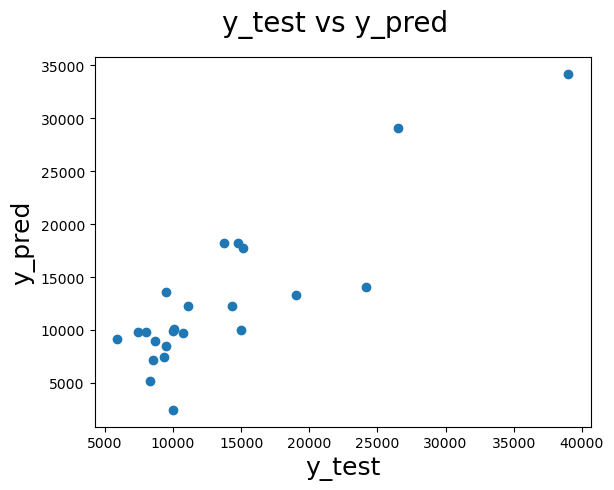

In [54]:
model_7 = BayesianRidge()
run_experiment(model_7)

R^2 :  0.7224333116987265
MAE : 3080.209911612265
MSE : 15303851.822361335
RMSE: 3912.01378095238


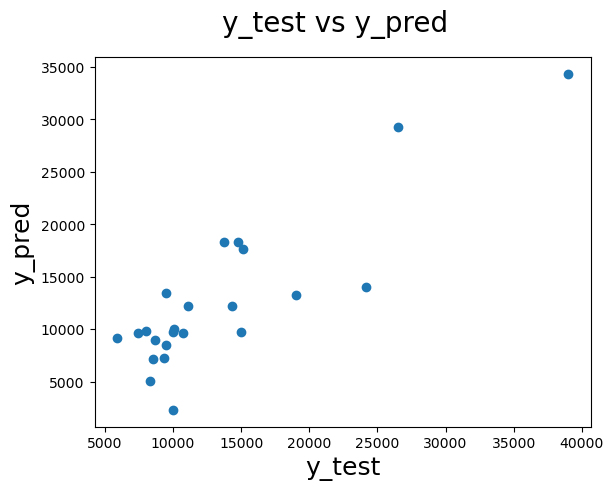

In [55]:
model_8 = SGDRegressor(max_iter=1000, tol=1e-3)
run_experiment(model_8)

R^2 :  -0.024161065115523517
MAE : 5030.884391824872
MSE : 56467904.267198846
RMSE: 7514.512909510426


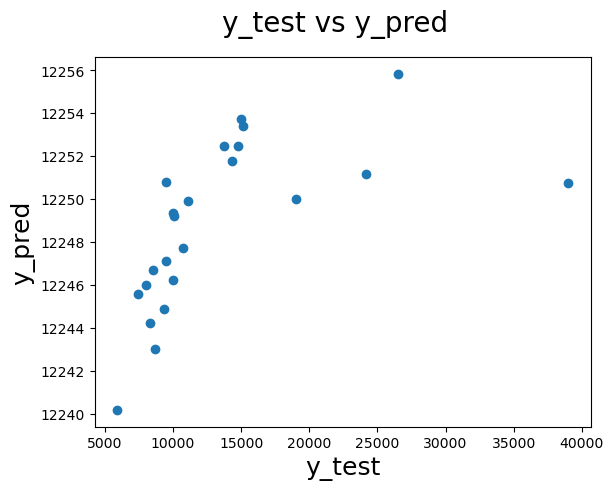

In [56]:
model_9 = SVR(epsilon=0.2)
run_experiment(model_9)

R^2 :  0.6796096850066627
MAE : 2511.244175669741
MSE : 17664965.259288322
RMSE: 4202.971003860046


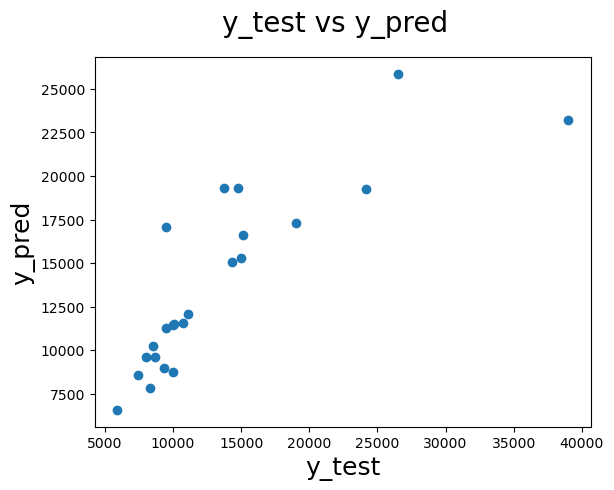

In [57]:
model_10 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_10)

[0.21419851 0.14289346 0.11817436 0.11931899 0.0363764  0.03294492
 0.03297934 0.04392762 0.02509754 0.03023689 0.0309843  0.02847799
 0.02471505 0.02390307 0.0274381  0.02594039 0.02124394 0.02114911]


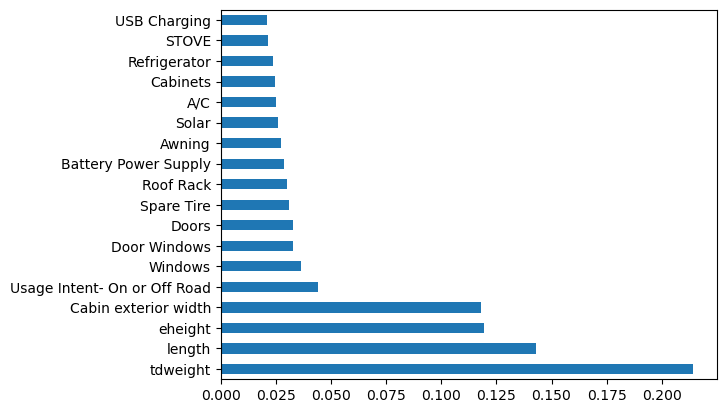

In [58]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances 
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()

## Hyperparameter Tuning
Perhaps it is a bit early to get into hyperparameter tuning, but nonetheless the code is ready for once the dataset has been expanded :) Commented out for time saving purposes.

In [59]:
rfc=RandomForestRegressor(random_state=0)

In [60]:
param_grid = { 
    'n_estimators': [100, 500, 1000],
   # 'max_features': ['auto', 'sqrt', 'log2'],
    #to save time in updating the notebook, max_depth is also left out
    'max_depth' : [5, 10, 15],
    'min_samples_leaf' : [1,2,3],
     #'criterion' :['squared_error', 'absolute_error', 'friedman_mse']
}


In [61]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [100, 500, 1000]})

In [62]:
#print the best parameters determined in GridSearchCV
CV_rfc.best_params_

{'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 1000}

R^2 :  0.6287487571686219
MAE : 2577.832194616977
MSE : 20469221.447034966
RMSE: 4524.292369756287


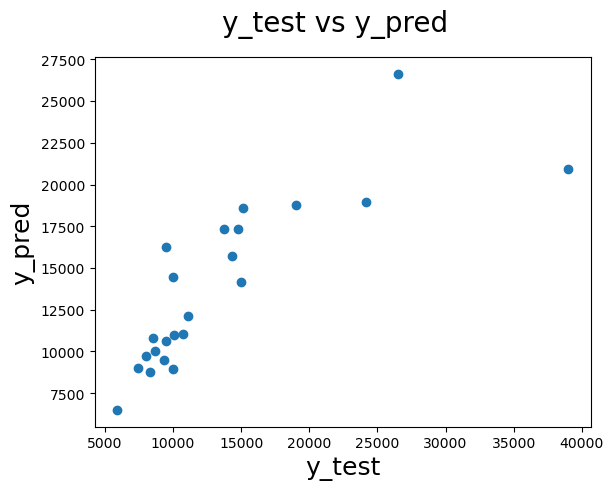

In [63]:
#run a final model using the optimal parameters
final_model = RandomForestRegressor(criterion= 'squared_error', n_estimators=1000, max_features='sqrt', max_depth=15, min_samples_leaf=1, random_state=0)
run_experiment(final_model)

# Checking the value of interest

In [64]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.05)

In [65]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

R^2 :  0.23193441586146668
MAE : 2308.0533333333324
MSE : 7654019.511263149
RMSE: 2766.5898704475785


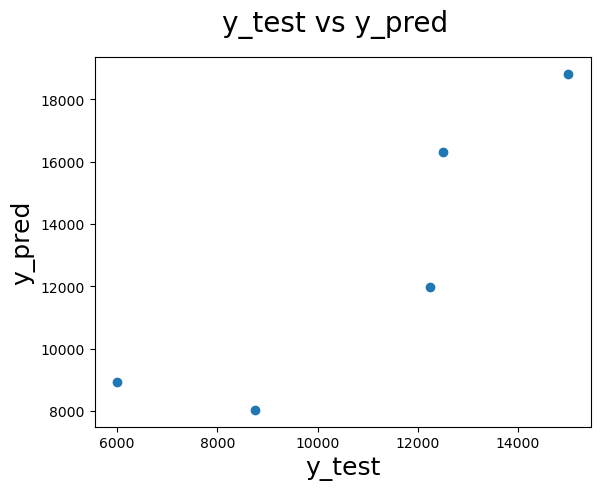

In [66]:
model_10 = RandomForestRegressor(n_estimators=1000, max_depth=15, min_samples_leaf=1, random_state=1)
run_experiment(model_10)

In [67]:
new_input = data.loc[90:]
new_input

,tdweight,length,Cabin exterior width,eheight,Windows,Doors,Door Windows,Rear Door Window,Rear Door,Wall Material,...,Roof Rack,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,price
90,850,144.0,93.0,72.0,4,2,2,2,3,0,...,2,1,0,0,0,1,0,0,0,9995
91,850,144.0,93.0,72.0,4,2,2,2,3,0,...,2,1,0,0,0,1,0,0,2,9995
92,850,144.0,93.0,72.0,4,2,2,2,3,0,...,2,1,0,0,0,1,0,2,2,9995
93,850,144.0,93.0,72.0,4,2,2,2,3,0,...,2,1,0,0,0,1,0,2,2,9995
94,850,144.0,93.0,72.0,4,2,2,2,3,0,...,2,1,0,0,0,1,2,2,2,9995


In [68]:
#drop the variable to be predicted
new_input=new_input.drop(['price', 'Wall Material', 'Rear Door', 'Rear Door Window'],axis=1)
new_input

,tdweight,length,Cabin exterior width,eheight,Windows,Doors,Door Windows,Usage Intent- On or Off Road,A/C,Roof Rack,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging
90,850,144.0,93.0,72.0,4,2,2,2,2,2,1,0,0,0,1,0,0,0
91,850,144.0,93.0,72.0,4,2,2,2,2,2,1,0,0,0,1,0,0,2
92,850,144.0,93.0,72.0,4,2,2,2,2,2,1,0,0,0,1,0,2,2
93,850,144.0,93.0,72.0,4,2,2,2,2,2,1,0,0,0,1,0,2,2
94,850,144.0,93.0,72.0,4,2,2,2,2,2,1,0,0,0,1,2,2,2


In [69]:
new_input_scaled = scaler.fit_transform(new_input)

In [70]:
new_output = model_10.predict(new_input_scaled)
new_output

array([11564.671     , 10897.82233333, 11272.46433333, 11272.46433333,
       11925.238     ])

###### <iframe src="https://www.kaggle.com/embed/faressayah/practical-introduction-to-10-regression-algorithm?cellIds=36&kernelSessionId=117768677" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Practical Introduction to 10 Regression Algorithm"></iframe>

# Runaway Test

Individual values of interest are checked using the final model 

In [71]:
#drop the actual test values, plus the values from this brand to exclude from the test set
data4=data3.drop(data.index[20:24])

In [72]:
#removing features which preformed worst in numerous tests 
X = data4.drop(['price'],axis=1)
y=data4['price']

In [73]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [74]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [75]:
def runaway_experiment(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("MSE :", mean_squared_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    #EVALUATION OF THE MODEL
    # Plotting y_test and y_pred to understand the spread.
    fig = plt.figure()
    plt.scatter(y_test,y_pred)
    fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
    plt.xlabel('y_test', fontsize=18)                          # X-label
    plt.ylabel('y_pred', fontsize=18) 


R^2 :  0.7152774148607256
MAE : 1830.33693990823
MSE : 5866228.521557256
RMSE: 2422.0298349849563


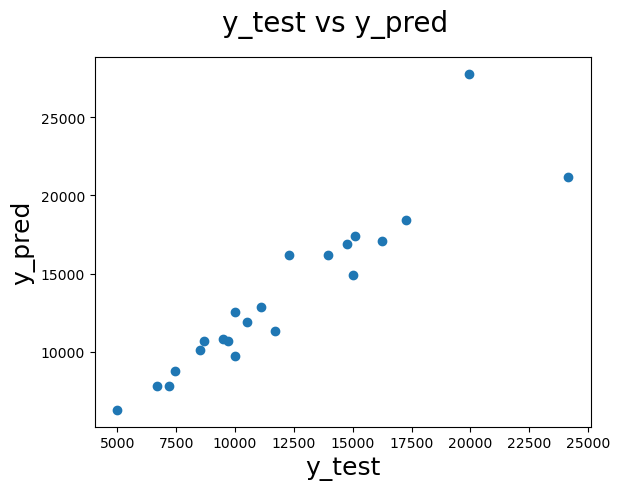

In [76]:
model_10 = RandomForestRegressor(n_estimators=500, max_features='auto', max_depth=5, min_samples_leaf=1, random_state=32)
#(criterion= 'squared_error', n_estimators=1000, max_features='sqrt', max_depth=15, min_samples_leaf=1, random_state=0)
#(n_estimators=5000, max_depth=15, min_samples_leaf=3, random_state=1)
runaway_experiment(model_10)

In [77]:
runaway = data.loc[20:24]
runaway

,tdweight,length,Cabin exterior width,eheight,Windows,Doors,Door Windows,Rear Door Window,Rear Door,Wall Material,...,Roof Rack,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,price
20,580,136.0,48.0,65.0,4,2,0,0,2,2,...,1,1,0,0,0,1,0,0,0,5995
21,765,136.0,72.0,65.0,4,4,0,0,2,2,...,1,1,0,0,0,1,0,0,0,7645
22,850,96.0,48.0,73.5,4,2,0,0,2,2,...,1,0,0,0,0,1,0,0,0,9650
23,1050,96.0,72.0,77.5,4,4,0,0,2,2,...,1,0,0,0,0,1,0,0,0,11945
24,840,136.0,72.0,87.0,4,2,2,0,1,2,...,1,1,0,0,0,1,0,0,0,9220


In [78]:
#drop the variable to be predicted
runaway_new=runaway.drop(['price'],axis=1)
#, 'Wall Material', 'Rear Door', 'Rear Door Window'
runaway_new

,tdweight,length,Cabin exterior width,eheight,Windows,Doors,Door Windows,Rear Door Window,Rear Door,Wall Material,...,A/C,Roof Rack,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging
20,580,136.0,48.0,65.0,4,2,0,0,2,2,...,2,1,1,0,0,0,1,0,0,0
21,765,136.0,72.0,65.0,4,4,0,0,2,2,...,2,1,1,0,0,0,1,0,0,0
22,850,96.0,48.0,73.5,4,2,0,0,2,2,...,2,1,0,0,0,0,1,0,0,0
23,1050,96.0,72.0,77.5,4,4,0,0,2,2,...,2,1,0,0,0,0,1,0,0,0
24,840,136.0,72.0,87.0,4,2,2,0,1,2,...,2,1,1,0,0,0,1,0,0,0


In [79]:
runaway_scaled = scaler.fit_transform(runaway_new)

In [80]:
rouser = runaway_new.loc[24:24]
rouser

,tdweight,length,Cabin exterior width,eheight,Windows,Doors,Door Windows,Rear Door Window,Rear Door,Wall Material,...,A/C,Roof Rack,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging
24,840,136.0,72.0,87.0,4,2,2,0,1,2,...,2,1,1,0,0,0,1,0,0,0


In [81]:
rouser_scaled = scaler.fit_transform(rouser)

In [82]:
rangerunner = runaway_new.loc[21:21]

In [83]:
rangerunner_scaled = scaler.fit_transform(rangerunner)

In [84]:
rouser_test = model_10.predict(rouser_scaled)
rouser_test

array([12986.55665067])

In [85]:
rangerunner_test = model_10.predict(rangerunner_scaled)
rangerunner_test

array([12986.55665067])

In [86]:
runaway_test = model_10.predict(runaway_scaled)
runaway_test

array([ 6906.3062232 ,  9848.90087865, 12599.60929291, 25816.55357359,
       12965.91855921])

5995, 7645, 9650, 11945, 9220